<h1 style='color: #fca311'>movies</h1>

In this notebook, I analyse the data that I have scraped from the IMDB and Metacritic websites. The files I used to scrape the data are imdb_movie_data_collection.py and metacritic_movie_data_collection.py. The IMDB data contains the top 1000 rated movies and the Metacritic data contains all movies on their site, totalling nearly 13,000.

In [1]:
import sys
sys.path.append('C:/Users/chade/AppData/Local/Programs/Python/Python38-32/Lib/site-packages/')
import pandas as pd
import sqlite3
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gender_guesser.detector as gender
from matplotlib.patches import Patch
%matplotlib notebook

<h2 style='color: #e63946'>imdb</h2>

In [2]:
conn = sqlite3.connect('movies.sqlite')
df = pd.read_sql('SELECT * FROM imdb', con=conn)
conn.close()

df.head()

,id,title,year,age_rating,run_time,genre,imdb_score,metascore,director,cast,votes,gross
0,1,The Shawshank Redemption,1994,MA,142,\nDrama,9.3,80.0,Frank Darabont,"Tim Robbins,Morgan Freeman,Bob Gunton,William ...",2253115,28341469.0
1,2,The Godfather,1972,R,175,"\nCrime, Drama",9.2,100.0,Francis Ford Coppola,"Marlon Brando,Al Pacino,James Caan,Diane Keaton",1554770,134966411.0
2,3,The Dark Knight,2008,M,152,"\nAction, Crime, Drama",9.0,84.0,Christopher Nolan,"Christian Bale,Heath Ledger,Aaron Eckhart,Mich...",2220190,534858444.0
3,4,The Godfather: Part II,1974,M,202,"\nCrime, Drama",9.0,90.0,Francis Ford Coppola,"Al Pacino,Robert De Niro,Robert Duvall,Diane K...",1086630,57300000.0
4,5,The Lord of the Rings: The Return of the King,2003,M,201,"\nAdventure, Drama, Fantasy",8.9,94.0,Peter Jackson,"Elijah Wood,Viggo Mortensen,Ian McKellen,Orlan...",1590756,377845905.0


In [3]:
# Age rating uniformity
# E and RC will still be skipped as they are very uncommon
ratings = {'R18+': 'R', 'MA15+': 'MA', 'NRC': 'PG', 'A': 'PG', 'SOA': 'R'}
accepted_ratings = ['R', 'MA', 'M', 'PG', 'G']

df.age_rating = df.age_rating.map(lambda x: ratings[x] if x in ratings.keys() else x)

<h3 style='color: #457b9d'>actors</h3>

Top ten most frequent actors with the average score for movies they appear in

In [4]:
# Converting cast column into a list of actors
df.cast = df.cast.map(lambda text: [actor.strip() for actor in re.findall('[^,]+', text)])
# Unnesting these lists of actors and grouping them by actor name, with an aggregate column for count and mean movie score
df_actors = df[['cast', 'imdb_score']].explode('cast').groupby('cast').agg(['mean', 'count'])
# Sorting to show the most frequently appearing actors at the top
df_actors = df_actors.sort_values(('imdb_score', 'count'), ascending=False)
# Display result
df_actors.head(10)

imdb_score      
                        mean count
cast                              
Robert De Niro      8.117647    17
Tom Hanks           8.042857    14
Al Pacino           8.076923    13
Clint Eastwood      7.958333    12
Brad Pitt           8.025000    12
Leonardo DiCaprio   8.127273    11
Christian Bale      8.045455    11
Matt Damon          8.009091    11
James Stewart       8.140000    10
Johnny Depp         7.744444     9

<h3 style='color: #457b9d'>directors</h3>

Top ten most frequent directors

In [5]:
df.director.value_counts().head(10)

Alfred Hitchcock     14
Steven Spielberg     14
Hayao Miyazaki       11
Akira Kurosawa       10
Martin Scorsese      10
Woody Allen           9
Stanley Kubrick       9
Billy Wilder          9
Quentin Tarantino     8
Christopher Nolan     8
Name: director, dtype: int64

<h3 style='color: #457b9d'>length & age rating</h3>

I've always thought that the most critcally acclaimed movies had a tendency to be violent and/or very long, perhaps due to being more realistic and having more time to develop characters. It would appear that longer movies and those with higher age ratings are over represented in the highest rated movies.

In [6]:
groupings = (10, 50, 100, 500, 1000)

# Creating a list of the proportion of movies rated either R or MA in each of the groupings sizes
impact_lst = [len(df[(df.id < (i + 1)) & (df.age_rating.isin(['R', 'MA']))])/i for i in groupings]

# Getting the average movie length for each of the groupings sizes
length_lst = [df[(df.id < i + 1)].run_time.mean() for i in groupings]

# Creating labels for our charts
group_labels = ['Top ' + str(i) for i in groupings]
y_pos = np.arange(len(groupings)) 

<IPython.core.display.Javascript object>


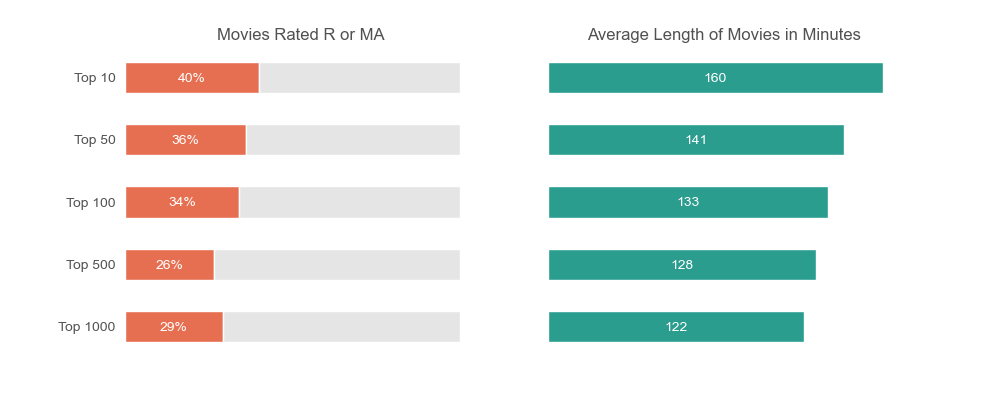

In [17]:
# Building a plot
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

sns.set_style('white')
height = 0.5

# # Age Rating
bar_plot = ax[0].barh(y_pos, impact_lst, height=height, color='#e76f51')
ax[0].barh(y_pos, [1 - i for i in impact_lst], left=impact_lst, height=height, color='#e5e5e5')

ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(group_labels, alpha=0.8)
ax[0].invert_yaxis()
ax[0].get_xaxis().set_visible(False)
ax[0].set_title('Movies Rated R or MA', alpha=0.8)

# Adding text onto bars
for idx, rect in enumerate(bar_plot):
        width = rect.get_width()
        ax[0].text(width/2, idx+0.12,
                '{}%'.format(int(impact_lst[idx] * 100)),
                ha='center', va='bottom', rotation=0, color='white')

# Length
bar_plot = ax[1].barh(y_pos, length_lst, height=height, color='#2a9d8f')

ax[1].get_xaxis().set_visible(False)
ax[1].set_title('Average Length of Movies in Minutes', alpha=0.8)

for i in ('top', 'left', 'right', 'bottom'):
    ax[0].spines[i].set_visible(False)
    ax[1].spines[i].set_visible(False)

# Adding text onto bars
for idx, rect in enumerate(bar_plot):
        width = rect.get_width()
        ax[1].text(width/2, idx+0.12,
                int(length_lst[idx]),
                ha='center', va='bottom', rotation=0, color='white')

fig.show()

<h3 style='color: #457b9d'>gender</h3>

Perhaps unsurprisingly, the IMDB list is very male dominated. Approximately 96% of all films in the list of 1000 were directed by a man. Furthermore, nearly a quarter of these 1000 movies featured an all male starring cast and 69% of starring acting performances were by a man.

In [8]:
# Gender of directors. Using gender detector library.
d = gender.Detector()
# Getting gender of director from first name
df['director_gender'] = df.director.map(lambda x: d.get_gender(x.split()[0]))
# Count of male directors
male_directors = len(df[df.director_gender.isin(['male', 'mostly_male'])])
# Count of female directors
female_directors = len(df[df.director_gender.isin(['female', 'mostly_female'])])

# Proportion of films directed by a man
male_directors/(male_directors + female_directors)

0.9643652561247216

In [9]:
# Movies with an all male cast
def all_male(x):
    """Looks through all names in a list and will return true if all names are male"""
    if type(x) != list:
        return None
    
    male_found = False
    
    for name in x:
        if d.get_gender(name.split()[0]) in ('female', 'mostly_female'):
            return False
        elif d.get_gender(name.split()[0]) in ('male', 'mostly_male'):
            male_found = True
    
    if male_found:
        return True
    return None

# Mapping this function to all rows
df['cast_gender'] = df.cast.map(all_male)

# Proportion of movies with an all male starring cast 
df.cast_gender.sum()/(len(df.cast_gender.dropna()))

0.2347560975609756

In [10]:
# Mapping the gender for each actor
df_actors['gender'] = df_actors.index.map(lambda x: d.get_gender(x.split()[0]))

male_actor_appearances = df_actors[df_actors.gender.isin(['male', 'mostly_male'])][('imdb_score', 'count')].sum()
female_actor_appearances = df_actors[df_actors.gender.isin(['female', 'mostly_female'])][('imdb_score', 'count')].sum()

# Proportion of starring acting performances that were by a man
male_actor_appearances/(male_actor_appearances + female_actor_appearances)

0.6903243692819517

<h2 style='color: #e63946'>metacritic</h2>

In [11]:
conn = sqlite3.connect('movies.sqlite')
df = pd.read_sql('SELECT * FROM metacritic', con=conn)
conn.close()

df.head()

,id,title,year,meta_score,user_score,cast,director,genre,age_rating,run_time
0,1,Citizen Kane,1941,100,8.5,"Joseph Cotten,Orson Welles",Orson Welles,"Drama,Mystery",Approved,119
1,2,The Godfather,1972,100,9.2,"Al Pacino,Marlon Brando",Francis Ford Coppola,"Drama,Thriller,Crime",R,175
2,3,Rear Window,1954,100,8.8,"Frank Cady,Georgine Darcy,Grace Kelly,James St...",Alfred Hitchcock,"Mystery,Thriller",TV-G,112
3,4,Casablanca,1943,100,8.9,"Humphrey Bogart,Ingrid Bergman",Michael Curtiz,"Drama,Romance,War",TV-PG,102
4,5,Boyhood,2014,100,7.6,"Bonnie Cross,Elijah Smith,Ellar Coltrane,Ethan...",Richard Linklater,Drama,R,165


<h3 style='color: #457b9d'>genre</h3>

In the graph below, I show the top four genres by mean score compared with the bottom four genres by mean score. Genres that appeared less than 10 times were removed.

In [12]:
# Changing the genre column to become a list a genres
df.genre = df.genre.map(lambda text: [genre.strip() for genre in re.findall('[^,]+', text)])

# Removing genres that appear twice in the same description by using a set
df.genre = df.genre.map(lambda lst: list(set(lst)))

# Unnesting the genre column and aggregating by mean movie score and count
df_genre = df[['genre', 'meta_score']].explode('genre').groupby('genre').agg(['mean', 'count'])

# Removing genres that appear less than 10 times
df_genre = df_genre[df_genre[('meta_score', 'count')] >= 10]

# Sorting by rating
df_genre = df_genre.sort_values(('meta_score', 'mean'), ascending=False)

# Grabbing the first four and last four items
df_genre = pd.concat([df_genre[:4], df_genre[-4:]])

<IPython.core.display.Javascript object>


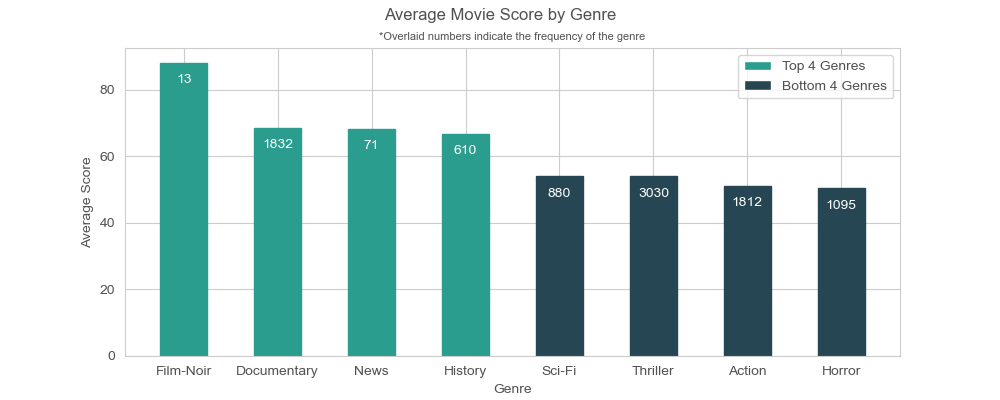

In [13]:
# Creating a plot

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 4))
bar_plot = ax.bar(df_genre.index, df_genre[('meta_score', 'mean')], width=0.5)

plt.suptitle('Average Movie Score by Genre', alpha=0.8)
ax.set_title('*Overlaid numbers indicate the frequency of the genre', fontsize=8, alpha=0.8)
plt.ylabel('Average Score', alpha=0.8)
plt.xlabel('Genre', alpha=0.8)
plt.xticks(alpha=0.8)
plt.yticks(alpha=0.8)

# Changing colors and adding in overlaid text
for idx, rect in enumerate(bar_plot):
    if idx < 4:
        rect.set_color('#2a9d8f')
    else:
        rect.set_color('#264653')
        
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height - 7,
            df_genre[('meta_score', 'count')][idx],
            ha='center', va='bottom', rotation=0, color='white')

# Lines for legend
custom_lines = [Patch(facecolor='#2a9d8f', label='Top 4 Genres'),
                Patch(facecolor='#264653', label='Bottom 4 Genres')]    

leg = ax.legend(handles=custom_lines)

for txt in leg.texts:
    txt.set_alpha(0.8)

fig.show()

<h3 style='color: #457b9d'>actors</h3>

Below is a list of the best performing actors (judged by the mean score of movies they have appeared in) for actors who have appeared in at least 10 movies.

In [14]:
# Removing movies without a cast
df.dropna(subset=['cast'], inplace=True)

# Converting cast column into a list of actors
df.cast = df.cast.map(lambda text: [actor.strip() for actor in re.findall('[\w]+ [\w]+[^,]*', text)])
# Unnesting these lists of actors and grouping them by actor name, with an aggregate column for count and mean movie score
df_actors = df[['cast', 'meta_score']].explode('cast').groupby('cast').agg(['mean', 'count'])
# Showing the top ten actors by mean movie score for actors appearing at least 10 times
df_actors[df_actors[('meta_score', 'count')] >= 10].sort_values(('meta_score', 'mean'), ascending=False)[:10]

meta_score      
                          mean count
cast                                
James Stewart        87.500000    10
Marlon Brando        80.181818    11
Daniel Day-Lewis     77.384615    13
Tony Leung Chiu Wai  75.900000    10
Michael Stuhlbarg    75.500000    12
George C. Scott      74.800000    10
Mathieu Amalric      74.000000    15
Andy Serkis          72.857143    14
Tilda Swinton        72.750000    24
Samantha Morton      72.100000    10

<h3 style='color: #457b9d'>directors</h3>

Below is a list of the best performing directors (judged by the mean score of movies they have directed) for directors who have directed at least 10 movies.

In [15]:
# Resetting this after being altered in the previous cell
conn = sqlite3.connect('movies.sqlite')
df = pd.read_sql('SELECT * FROM metacritic', con=conn)
conn.close()

# Grouping by directors and making the dataframe output look pretty
directors = df[['director', 'meta_score']].groupby('director').agg({'director':'size', 'meta_score':'mean'})
directors = directors.rename(columns={'director': 'Movies Directed', 'meta_score': 'Average Score'})
directors = directors.reset_index().rename(columns={'director': 'Director'})
directors = directors[directors['Movies Directed'] >= 10].sort_values('Average Score', ascending=False)[:10]
directors.index = np.arange(1, 11)
directors

,Director,Movies Directed,Average Score
1,Alfred Hitchcock,19,84.894737
2,Hayao Miyazaki,10,83.700000
3,Mike Leigh,13,81.769231
4,Hirokazu Koreeda,12,80.666667
5,Martin Scorsese,28,79.107143
6,Noah Baumbach,10,76.700000
7,Robert Altman,19,76.105263
8,Christopher Nolan,10,75.800000
9,Claire Denis,10,75.300000
10,Sang-soo Hong,12,75.250000


<h3 style='color: #457b9d'>age</h3>

It appears that movies that are older tend to receive a higher score as per below graph.

<IPython.core.display.Javascript object>


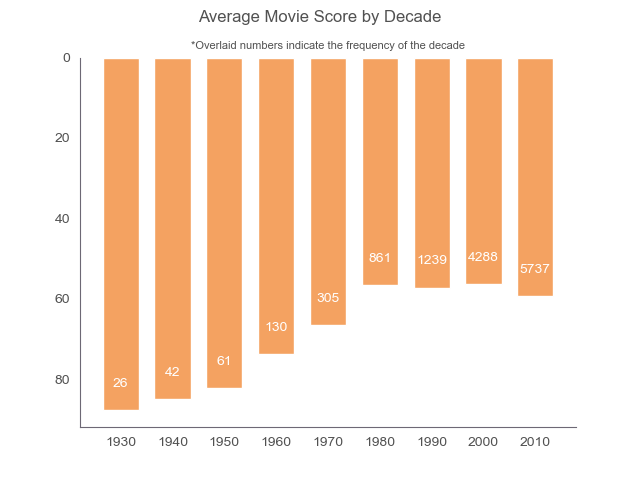

In [16]:
# Years 
year_to_score = df[['year', 'meta_score']].dropna()
my_bins = {}
bar_labels = []

sns.set_style('white')

for i in range(1930, 2020, 10):
    my_bins[i] = df[df.year.between(i, i+9)].meta_score.mean()
    x = len(df[df.year.between(i, i+9)])
    bar_labels.append(x)

# Plotting
fig, ax = plt.subplots()
bar_plot = plt.bar(my_bins.keys(), my_bins.values(), width=7, color='#f4a261')
plt.xticks([x for x in range(1930, 2020, 10)], my_bins.keys(), alpha=0.8)
plt.yticks(alpha=0.8)

# Turning axis upside down
ax.invert_yaxis()

plt.suptitle('Average Movie Score by Decade', alpha=0.8)
ax.set_title('*Overlaid numbers indicate the frequency of the decade', fontsize=8, alpha=0.8)

for i in ('top', 'right'):
    ax.spines[i].set_visible(False)
    
for i in ('left', 'bottom'):
    ax.spines[i].set_color('#6D6875')

# Function for adding text onto the bars
def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height - 5,
                bar_labels[idx],
                ha='center', va='bottom', rotation=0, color='white')

# Applying this function
autolabel(bar_plot)

fig.show()